# Multivariate LSTM Regression

LSTM is a special architecture of Recurrent Neural Networks (RNN). It might be considered as an integral part of sequence to sequence learning phenomenon. It is customary to come across LSTM in natural language processing studies.

Unlike traditional time series forecasting techniques such as `ARIMA`, we conducted a Multivariate LSTM Regression to predict next day's lead number. We were considered days as time steps and products, and channels as features. 

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
sns.set(style="darkgrid", context="notebook")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from tensorflow.keras import layers

from zipfile import ZipFile

import warnings
warnings.filterwarnings("ignore")

print(tf.version.VERSION)
print(keras.__version__)

2.7.0
2.7.0


# Data Preparing

In [3]:
ZipFile("transactions.csv.zip", "r").extractall()
data = pd.read_csv("transactions.csv")

In [4]:
df = data.copy()

- Data set has duplications in terms of `ga_transactionid`. If it represents a unique transaction, different interests of products, and interests coming different channels in same transaction are possible. Therefore, we cleaned duplicates in two scenarios: clening based on `subset=["ga_transactionid", "ga_products"]` cleaning and cleaning based on `subset=["ga_transactionid", "ga_channels"]`

- We pivoted two different tables, one of which represents interests to products on daily basis, and other one reflects interests coming from different channels.

- We observed null values in channels data, and we discarded them from result set.

- Date 18.10.2021 seemed not to inclue valid records, so we dropped last day.

- Since, data set spends large amount of memory, it is better to save it as a temporary file, and clean all other variables to gain free memory. 

In [5]:
df["ga_channels"] = df["ga_channels"].fillna("NA")
df["ga_datehour"] = df["ga_datehour"].astype("str")

f = df.ga_datehour
df["date"] = f.str.slice(0,4)+"-"+f.str.slice(4,6)+"-"+f.str.slice(6,8)
df["hour"] = f.str.slice(8,10).astype("int")
df["date"] = df["date"].astype("datetime64")

prod = df.drop_duplicates(subset=["ga_transactionid", "ga_products"],
                          ignore_index=True)

channel = df.drop_duplicates(subset=["ga_transactionid", "ga_channels"],
                             ignore_index=True)

prod_pvt = pd.pivot_table(df, index="date",
                          columns="ga_products",
                          values="ga_itemquantity",
                          aggfunc=np.sum)

channel_pvt = pd.pivot_table(df, index="date",
                             columns="ga_channels",
                             values="ga_itemquantity",
                             aggfunc=np.sum)

prod_pvt.drop(prod_pvt.index[-1], inplace=True)
channel_pvt.drop(channel_pvt.index[-1], inplace=True)

prod_pvt["daily_sum"] = prod_pvt.sum(axis=1)

time_data = pd.concat([prod_pvt, channel_pvt], axis=1)
time_data.drop(columns="NA", inplace=True)
time_data.to_csv("time_data.csv", index="date")

del channel, channel_pvt, data, df, f, prod_pvt, prod

In [ ]:
time_data = pd.read_csv("time_data.csv", index_col="date")

From the graph below it is obvious that `Product D` and `Google Ads` are most utilized features. One can say that some products and channels could not provide as sufficient information as others.  

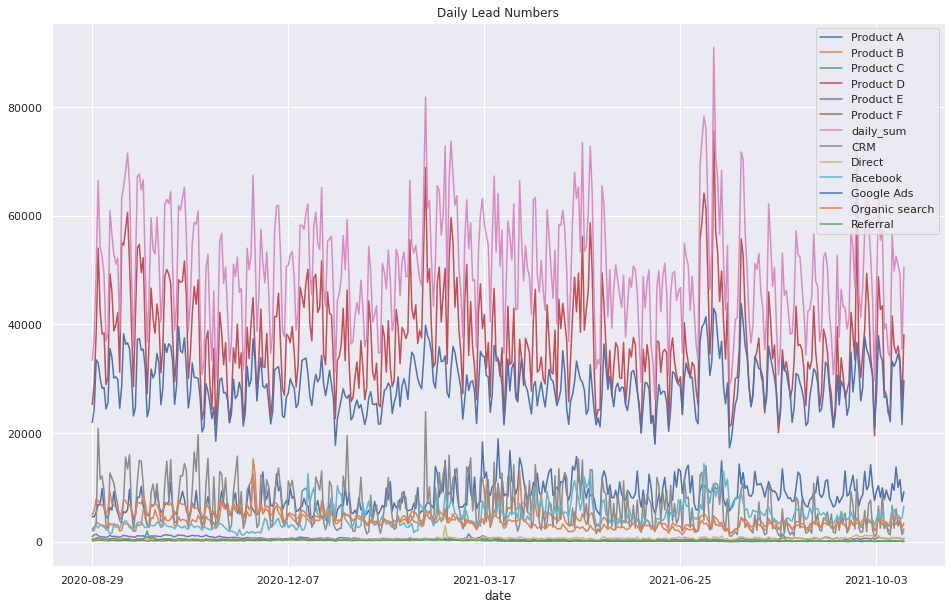

In [7]:
df = time_data.copy()
df.plot(figsize=(16,10), legend=True)
plt.title("Daily Lead Numbers")
plt.show()

Function below was adopted an article in `machinelearningmastery.com`. It transforms tabular data into sequence data taking time steps argument as `n_in`. 

In [9]:
def series_to_supervised(data, n_in=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [("var%d(t-%d)" % (j+1, i)) for j in range(n_vars)]
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg

- `time_step` is an experimental parameter which must be adjusted to. In early trials models resulted well around 30. 

- 75 of the records out of 415 might be held as test records.

- Data was normalized different scales for variables and response.

- LSTM receives data as `batch_size, time_steps, n_features` shape, so we reshaped the data with `np.reshape()`  

In [10]:
time_step = 30
n_train = 320

sc_X = MinMaxScaler(feature_range=(0,1))
sc_y = MinMaxScaler(feature_range=(0,1))

reframed = series_to_supervised(df, time_step)
reframed = reframed.merge(df["daily_sum"], how="left", on="date")

X_scaled = sc_X.fit_transform(reframed.drop(columns="daily_sum"))
y_scaled = sc_y.fit_transform(reframed["daily_sum"].values.reshape(-1, 1))

X_train, X_test = X_scaled[:n_train, :], X_scaled[n_train:, :]
y_train, y_test = y_scaled[:n_train, :], y_scaled[n_train:, :]

X_train = np.reshape(X_train, (X_train.shape[0], time_step, df.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], time_step, df.shape[1]))

# Modeling

## Configuration -1

First configuration comprises of two stacked LSTM layer. One of them outputs with 3 dimension with `return_sequences=True` argument. The last LSTM layer gives 2 dimesional data to a dense layer. 

In [11]:
input_lead = layers.Input(shape=(X_train.shape[1], X_train.shape[2]),
                          name="input_lead")
lstm = layers.LSTM(units=128, return_sequences=True)(input_lead)
lstm = layers.Dropout(0.2)(lstm)

lstm = layers.LSTM(units=128)(lstm)
lstm = layers.Dropout(0.2)(lstm)

output = layers.Dense(1, name="output")(lstm)
model_1 = keras.Model(input_lead, output, name="model_1")
model_1.compile(loss="mean_squared_error",
                optimizer=keras.optimizers.Adam(learning_rate=0.0001))
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_lead (InputLayer)     [(None, 30, 13)]          0         
                                                                 
 lstm (LSTM)                 (None, 30, 128)           72704     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 204,417
Trainable params: 204,417
Non-trainab

In [12]:
model_1.fit(X_train, y_train,
            epochs=20,
            batch_size=10,
            validation_data=(X_test, y_test),
            verbose=1)

Epoch 1/20
32/32 [==============================] - 10s 52ms/step - loss: 0.0550 - val_loss: 0.0211
Epoch 2/20
32/32 [==============================] - 1s 23ms/step - loss: 0.0278 - val_loss: 0.0210
Epoch 3/20
32/32 [==============================] - 1s 23ms/step - loss: 0.0266 - val_loss: 0.0202
Epoch 4/20
32/32 [==============================] - 1s 23ms/step - loss: 0.0270 - val_loss: 0.0202
Epoch 5/20
32/32 [==============================] - 1s 22ms/step - loss: 0.0253 - val_loss: 0.0215
Epoch 6/20
32/32 [==============================] - 1s 23ms/step - loss: 0.0267 - val_loss: 0.0202
Epoch 7/20
32/32 [==============================] - 1s 22ms/step - loss: 0.0242 - val_loss: 0.0202
Epoch 8/20
32/32 [==============================] - 1s 23ms/step - loss: 0.0240 - val_loss: 0.0209
Epoch 9/20
32/32 [==============================] - 1s 22ms/step - loss: 0.0261 - val_loss: 0.0212
Epoch 10/20
32/32 [==============================] - 1s 22ms/step - loss: 0.0238 - val_loss: 0.0202
Epoch 11

In [13]:
y_pred = model_1.predict(X_test)
mean_squared_error(y_test, y_pred)

0.022954038789664892

Inference for days of the last two months

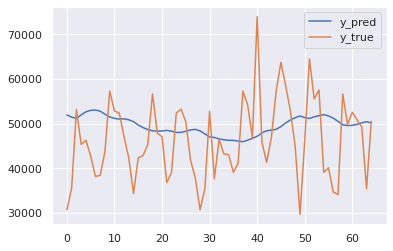

In [18]:
y_pred_ = sc_y.inverse_transform(y_pred)
y_test_ = sc_y.inverse_transform(y_test)

plt.plot(y_pred_)
plt.plot(y_test_)
plt.legend(["y_pred", "y_true"])
plt.show()

## Configuration -2

The alternative model includes two LSTM layers each of which within a Bidirectional layer. Its total parameter number greater than the first one.

In [19]:
input_lead = layers.Input(shape=(time_step, X_train.shape[2]),
                            name="input_lead")
b = layers.Bidirectional(layers.LSTM(units=200,
                                    return_sequences=True))(input_lead)
b = layers.Bidirectional(layers.LSTM(units=150))(b)
d = layers.Dense(20, activation="tanh")(b)
d = layers.Dropout(0.2)(d)
output = layers.Dense(1, name="output")(d)
model_2 = keras.Model(input_lead, output)
model_2.compile(loss="mean_squared_error",
                optimizer=keras.optimizers.Adam(learning_rate=0.0001))
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_lead (InputLayer)     [(None, 30, 13)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 30, 400)          342400    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 300)              661200    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 20)                6020      
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 output (Dense)              (None, 1)                 21    

In [20]:
model_2.fit(X_train, y_train,
            epochs=20,
            batch_size=10,
            validation_data=(X_test, y_test),
            verbose=1)

Epoch 1/20
32/32 [==============================] - 9s 106ms/step - loss: 0.0369 - val_loss: 0.0210
Epoch 2/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0280 - val_loss: 0.0205
Epoch 3/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0277 - val_loss: 0.0205
Epoch 4/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0272 - val_loss: 0.0198
Epoch 5/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0263 - val_loss: 0.0207
Epoch 6/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0252 - val_loss: 0.0198
Epoch 7/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0248 - val_loss: 0.0196
Epoch 8/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0247 - val_loss: 0.0201
Epoch 9/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0249 - val_loss: 0.0194
Epoch 10/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0260 - val_loss: 0.0197
Epoch 11

In [21]:
y_pred = model_2.predict(X_test)
mean_squared_error(y_test, y_pred)

0.019009212100124222

Inference for days of the last two months

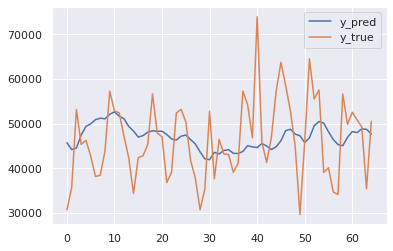

In [22]:
y_pred_ = sc_y.inverse_transform(y_pred)
y_test_ = sc_y.inverse_transform(y_test)

plt.plot(y_pred_)
plt.plot(y_test_)
plt.legend(["y_pred", "y_true"])
plt.show()

# Result

Even though we didn't perform any comprehensive parameter tuning, models' yields optimized trial and error manner. As a result, additional LSTM and dense layers didn't record any improvement. Rmsprop and Adam optimizers were both conducted, and Adam's results slightly outperformed the other optimizer's.
As a learning rate 0.0001 yielded better than 0.001.

According to first experiments model configuration 2 is obviously better than the first one. 

# References

[machinelearningmastery.com](https://machinelearningmastery.com/how-to-develop-baseline-forecasts-for-multi-site-multivariate-air-pollution-time-series-forecasting/)

[towardsdatascience.com](https://towardsdatascience.com/how-to-convert-pandas-dataframe-to-keras-rnn-and-back-to-pandas-for-multivariate-regression-dcc34c991df9)